<a href="https://colab.research.google.com/github/val93s/Machine_learning/blob/main/Copy_of_11_15_3_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activity 11.15.3

In this activity, we will use reinforcement learning to teach a cart to move so that a wobbly pole balanced on top of it remains upright.


##Step 1: Install the necessary packages


```
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

```

In [ ]:
#Step 1
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package list

##Step 2: Create the environment
* Run the following code block to create our wiggly pole and cart environment.
* The black rectangle is the cart.

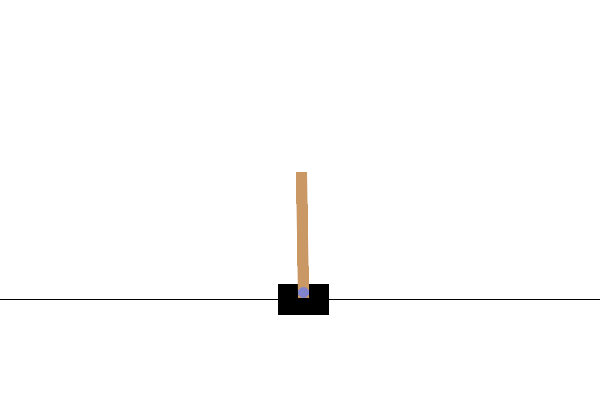

In [ ]:
#Step 2

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

num_iterations = 20000 

initial_collect_steps = 100  
collect_steps_per_iteration =   1# 
replay_buffer_max_length = 100000  # 

batch_size = 64  
learning_rate = 1e-3  
log_interval = 200  # 

num_eval_episodes = 10  
eval_interval = 1000  

env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

env.reset()
PIL.Image.fromarray(env.render())

##Step 3: Get information from the evironment
* Run the following code block to view the kinds of information our agent receives from the environment at each time point.  The goal is to move the cart right and left so the pole remains upright.  
* There are two time steps shown here.  We see the pole at one time step, move the cart with the `action=` step, and then view the state of the cart at the next time step.
* `observation` gives 4 measures of the angle and velocity of the pole and the cart.
* `reward` gives the value of the reward given to the agent at that time point.
* The cart can take two possible actions: `0` = move left and `1` = move right.
* If the angle of the pole becomes too great (i.e., the pole is going to fall over) the agent *loses* and the environment is reset.

In [ ]:
#Step 3

time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02830063,  0.01099067,  0.03210641, -0.04869228], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02852044,  0.20563787,  0.03113257, -0.33107495], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


##Step 4: Set up the agent
* This is where the neural network part of reinforcement learning comes in.  The agent will learn how to move the cart in response to the angle and velocity of the pole, so it stays upright.
* Run the following code block to create the agent.

In [ ]:
#Step 4

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

##Step 5: Set up a policy
* Run the following code block to define the policy, which is the set of rules for how the agent interacts with the environment (for example, the cart can move right and left, but it can't take off and fly around).
* The goal is to train the underlying model until the policy produces the desired outcome—keeping the pole balanced on top of the cart.


In [ ]:
#Step 5

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

time_step = example_environment.reset()

random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

##Step 6: Define performance metrics
* The agent needs to know how well it is operating in the environment.  At every time step, the agent is given a reward.  The agent's goal is to maximize the reward it gets every time it interacts with the environment.  
* If the pole falls over very quickly, the agent will not get much of a reward.  
* Run the following code block to build a function that calculates the average return for a policy.  
* The output is the average return for an agent that is acting completely at random.  We can use this as a baseline to see how training improves our agent's ability to balance the pole.


In [ ]:
#Step 6

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, num_eval_episodes)

20.8

##Step 7: Collect data
Run the following code block to collect data from the environment and save it in a replay buffer that can be used to train the agent.

In [ ]:
#Step 7

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


##Step 8: Train the agent
* Run the following code block to train the agent based on data collected from the environment.
* **Note**: This step will take about 5 minutes to run.

In [ ]:
#Step 8

agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 25.294822692871094
step = 400: loss = 2.503615379333496
step = 600: loss = 2.6476359367370605
step = 800: loss = 9.786568641662598
step = 1000: loss = 12.270898818969727
step = 1000: Average Return = 64.19999694824219
step = 1200: loss = 68.95333099365234
step = 1400: loss = 285.97564697265625
step = 1600: loss = 50.49403381347656
step = 1800: loss = 90.6613540649414
step = 2000: loss = 361.3363037109375
step = 2000: Average Return = 126.5999984741211
step = 2200: loss = 699.61669921875
step = 2400: loss = 340.458984375
step = 2600: loss = 3089.79736328125
step = 2800: loss = 5473.8427734375
step = 3000: loss = 174.86770629882812
step = 3000: Average Return = 90.5
step = 3200: loss = 240.0093994140625
step = 3400: loss = 191.07244873046875
step = 3600: loss = 149.5358428955078
step = 3800: loss = 108.89762115478516
step = 4000: loss = 58.95961380004883
step = 4000: Average Return = 169.1999969482422
step = 4200: loss = 58.787925720214844
step = 4400: loss = 73.075469

##Step 9: Watch the system in action
Run the following code block to view a demo video of the cart learning how to balance the pole.

In [ ]:
#Step 9

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

##Step 10: Compare to an untrained system
For comparison, run the following code block to show the cart moving at random.

In [ ]:
#Step 10:

create_policy_eval_video(random_policy, "random-agent")